In [1]:
"""
    Copyright (c) 2021 Olivier Leblanc

    Permission is hereby granted, free of charge, to any person obtaining
    a copy of this software and associated documentation files (the "Software"),
    to deal in the Software without restriction, including without limitation
    the rights to use, copy, modify, merge, publish, distribute, and to permit
    persons to whom the Software is furnished to do so.
    However, anyone intending to sublicense and/or sell copies of the Software
    will require the official permission of the author.
    ----------------------------------------------------------------------------

    Author : Olivier Leblanc
    Date : 15/11/2022

    Code description :
    __________________
    Reconstructs a piecewise constant 2D object using the ROP model and PyUnLocBox and PyProximal packages.
"""
import matplotlib.pyplot as plt
import numpy as np
from pyunlocbox import functions, solvers
import imageio
import pylops
import pyproximal

import sys, os
def updir(d, n):
  for _ in range(n):
    d = os.path.dirname(d)
  return d
sys.path.append(os.path.join(updir(os.getcwd(),2),'utils'))

from interferometric_lensless_imaging import * # ROP projectors, rmdiag,...
from functions import PSNR, imresample
from graphics import *

c:\Users\leblanco.OASIS\Anaconda3\lib\site-packages\llvmlite\llvmpy\__init__.py:3: UserWarning: The module `llvmlite.llvmpy` is deprecated and will be removed in the future.
  warnings.warn(
c:\Users\leblanco.OASIS\Anaconda3\lib\site-packages\llvmlite\llvmpy\core.py:8: UserWarning: The module `llvmlite.llvmpy.core` is deprecated and will be removed in the future. Equivalent functionality is provided by `llvmlite.ir`.
  warnings.warn(
c:\Users\leblanco.OASIS\Anaconda3\lib\site-packages\llvmlite\llvmpy\passes.py:17: UserWarning: The module `llvmlite.llvmpy.passes` is deprecated and will be removed in the future. If you are using this code, it should be inlined into your own project.
  warnings.warn(


<ipython-input-2-0a461f239f5e>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  f = imageio.imread(os.path.join(updir(os.getcwd(),2), "images/"+imname)) / 255.


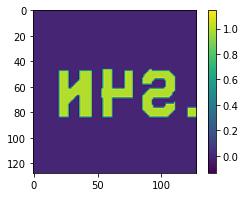

In [2]:
"Load an image"
imname = "f_ds.png" # cameraman.png, usaf.jpg
f = imageio.imread(os.path.join(updir(os.getcwd(),2), "images/"+imname)) / 255.
f = imresample(f, (128,128))
N = f.shape[0]

plt.figure(figsize=(4,3))
plt.imshow(f)
plt.colorbar()
plt.show()

In [3]:
M = 1500
Q = 120
maxit=150

"Parameters"
D = 176e-6 # MCF diameter
lamb = 1050e-9 # Laser wavelength
z = 500e-6 # Imaging depth
L = 300e-6 # Camera aperture width
Delta = L/N # Camera resolution [m/pixel]
lambz = lamb*z

"Cores positions"
pqx,pqy = LE_cores(D,Q)
Om_x = np.subtract.outer(pqx, pqx)
Om_y = np.subtract.outer(pqy, pqy)
Om_x2 = np.round(N*Om_x*Delta/lambz).astype(int)
Om_y2 = np.round(N*Om_y*Delta/lambz).astype(int)

"Apply FOV window"
x = np.linspace(-L/2,L/2,N)
xx,yy = np.meshgrid(x,x)
sig=L/8
# sqrtw = np.sqrt(np.exp(-(xx**2+yy**2)/(2*sig**2)))
sqrtw = np.ones(f.shape)
w=sqrtw**2

a_ij = (np.random.randn(M,Q)+1j*np.random.randn(M,Q))/np.sqrt(2) # Complex amplitude input to each core

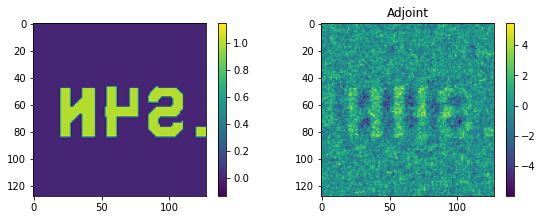

In [4]:
"PyUnlocbox"
g_ulb = lambda Xin: np.real(A(S_Om(T(w*Xin), Om_x2, Om_y2), a_ij, diagless=True))
gt_ulb = lambda Xin: np.real(w* T_star(S_Om_star(A_star2(Xin, a_ij, diagless=True), Om_x2, Om_y2, f.shape) ) )

y_ulb = g_ulb(f)
adjoint_ulb = gt_ulb(y_ulb)

"pyproximal"
Fop = pylops.signalprocessing.FFT2D(dims=f.shape)
Sop = pylops.S_Om(f.shape, Om_x2, Om_y2)
Rop = pylops.ROP(a_ij, diagless=True)
g_pyprox = Rop*Sop*Fop

y_pyprox = g_pyprox*f.reshape(-1)
adjoint_pyprox = (g_pyprox.T*y_pyprox).reshape(f.shape)

fig = plt.figure(figsize=(8,3))
axs = [fig.add_axes([0.05,0.1,0.4,0.8]), fig.add_axes([0.55,0.1,0.4,0.8])]
im0 = axs[0].imshow(w*f)
im1 = axs[1].imshow(adjoint_ulb)
axs[1].set_title('Adjoint')
fig.colorbar(im0, ax=axs[0])
fig.colorbar(im1, ax=axs[1])
plt.show()
plt.show()

Solve
\begin{equation*}
    \boldsymbol x^* = \argmin_{\boldsymbol u}~\frac{1}{2} \lVert \boldsymbol y - \boldsymbol{Au} \rVert^2 + \lambda \lVert \boldsymbol u \rVert_{\text{TV}} \text{ s.t. } \boldsymbol u > 0
\end{equation*}

using Generalized Forward-Backward algorithm:

\begin{equation*}
    \boldsymbol x^{(k+1)} = \text{prox}_{\gamma \lambda \lVert \cdot \rVert_{\text{TV}}} \left( \boldsymbol x^{(k)} - \gamma \nabla f(\boldsymbol x^{(k)}) \right)
\end{equation*}

We observe the reconstruction is much better when adding the positivity constrain!

Solution found after 150 iterations:
    objective function f(sol) = 5.003415e+02
    stopping criterion: MAXIT


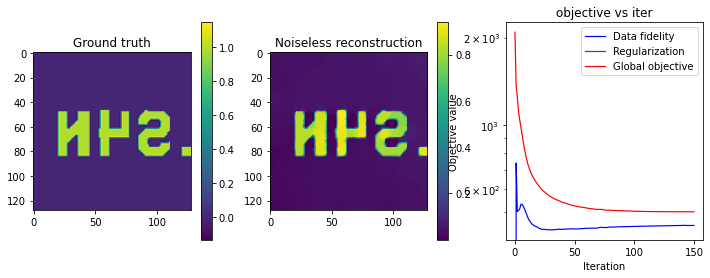

SNR: 12.89 dB
PSNR: 22.32


In [5]:
nu_rop = eval_nu(np.random.randn(N,N), g_ulb, gt_ulb, nb_iter=50)*1.01

solver = solvers.generalized_forward_backward(step=1/nu_rop )
f1 = functions.norm_tv(maxit=80, dim=2, lambda_ = 1e0)
f2 = functions.norm_l2(y=y_ulb, A=g_ulb, At=gt_ulb, nu=nu_rop)
f3 = functions.proj_positive()

x0 = np.zeros((N,N))
ret = solvers.solve([f1, f2, f3], x0, solver, rtol=1e-7, maxit=maxit) #, verbosity='NONE')

show_rec2D(f, np.abs(ret['sol']), objective=ret['objective'], show_Fourier=False, linewidth=1.2)
print("PSNR: {:.2f}".format(PSNR(f, ret['sol'].real)))

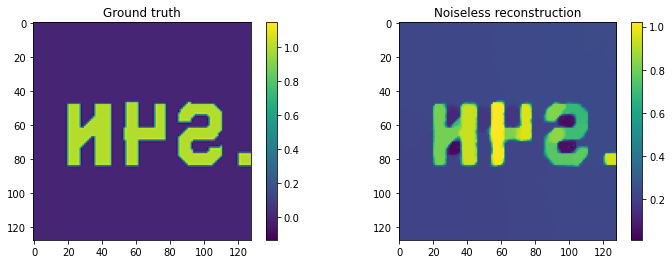

SNR: 3.55 dB


In [6]:
TV = pyproximal.TV(dims=(N,N), niter=80, rtol=1e-7, sigma=1e0)
l2 = pyproximal.L2(Op=g_pyprox, b=y_pyprox, sigma=1)
pos = pyproximal.Box(lower=0)

"Solve"
tau=0.5
x0 = np.zeros(N**2)

xhat = pyproximal.optimization.primal.GeneralizedProximalGradient(\
                                proxfs=[l2], proxgs=[TV, pos], x0=x0, tau=1/nu_rop, 
                                epsg=1, niter=maxit, acceleration='fista', show=False)
                                            
show_rec2D(f, xhat.reshape((N,N)), objective=None, linewidth=1.2)